In [1]:
from aux_func_V3 import *
import API_Numpy
import API_TensorFlow

import dill
import seaborn
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [2]:
def MalhaRetangular(N):
   Δ = 1.0/N
   Δx = Δ; Δy = Δ
   x = API_Numpy.arange(0.0,0.25+Δx,Δx)
   y = API_Numpy.arange(Δy,1.0,Δy)

   X = API_Numpy.stack([x]*y.shape[0],axis=1)
   Y = API_Numpy.stack([y]*x.shape[0],axis=0)

   return X, Y, Δ

In [3]:
def CondiçãoInicialRayleighTaylor(X, Y, γ):
   R = API_Numpy.zeros(X.shape)
   P = API_Numpy.zeros(X.shape)
   U = API_Numpy.zeros(X.shape)
   V = API_Numpy.zeros(X.shape)
   for i in range(X.shape[0]):
    for j in range(X.shape[1]):
      if Y[i,j] < 0.5:
         R[i,j] = 2.0
         P[i,j] = 2.0*Y[i,j] + 1.0
      else:
         R[i,j] = 1.0
         P[i,j] = Y[i,j] + 1.5
         
      a = API_Numpy.sqrt(γ * P[i,j] / R[i,j])
      V[i,j] = -0.025 * a * API_Numpy.cos(8.0*API_Numpy.pi*X[i,j])

   E = P/(γ-1.0) + R*(U**2 + V**2)/2.0
   Q0 = API_Numpy.stack([R, R*U, R*V, E],axis=0)
   n=X.shape[0]//2
   Q0[:,-n:,:]=API_Numpy.reverse(Q0[:,:n,:].copy(),axis=1)
   return Q0


In [4]:
def CondiçãoInicialRayleighTaylor_N(N, γ):
   X, Y, Δ = MalhaRetangular(N)
   Q0 = CondiçãoInicialRayleighTaylor(X, Y, γ)
   return X, Y, Δ, Q0

In [5]:
def RayleighTaylorGravity(Q,API):
   g = -1.0
   # for i = 1:size(U,1)
   #    for j = 1:size(U,2)
   #       F[i,j,3] = -g * U[i,j,1]
   #       F[i,j,4] = -g * U[i,j,3]
   #    end
   # end
   Z = Q[...,0:1,:,:]*0
   F = API.concat([Z,Z,-g*Q[...,0:1,:,:],-g*Q[...,2:3,:,:]],axis=-3)
   return F

In [6]:
def RayleighTaylorGhostPointsX(Q,API):
    left=API.stack([Q[...,0,:3,:],-Q[...,1,:3,:],Q[...,2,:3,:],Q[...,3,:3,:]],axis=-3)
    left=API.reverse(left,axis=[-2])

    center=Q

    right=API.stack([Q[...,0,-3:,:],-Q[...,1,-3:,:],Q[...,2,-3:,:],Q[...,3,-3:,:]],axis=-3)
    right=API.reverse(right,axis=[-2])

    return API.concat([left,center,right],axis=-2)

def RayleighTaylorGhostPointsY(Q,API):
   raw_ref_shape=API.shape(Q)[:-3]
   out_shape=API.concat([API.shape(Q)[:-1],[3]],axis=0)
   ref_shape=API.concat([API.ones(API.shape(raw_ref_shape),dtype='int32'),[4],[1],[1]],axis=0)
   vals_left=API.reshape([2.0,0.0,0.0,1.0/(γ-1.0)],ref_shape)
   vals_right=API.reshape([1.0,0.0,0.0,2.5/(γ-1.0)],ref_shape)
   Qg = [API.ones(out_shape,'float64')*API.cast(vals_left,'float64'),
         Q,
        API.ones(out_shape,'float64')*API.cast(vals_right,'float64')]
   return API.concat(Qg,-1)

In [7]:
WENO_Z_sim=lambda ε:simulation_2D(API_TensorFlow,
                        euler_equation_2D,
                        WENO_Z,
                        ε=ε)

WENO_Zp_sim=lambda ε:simulation_2D(API_TensorFlow,
                        euler_equation_2D,
                        WENO_Z_plus,
                        ε=ε)

WENO_Z_MS_sim=lambda ε:simulation_2D(API_TensorFlow,
                        euler_equation_2D,
                        WENO_Z,
                        map_function=Hong_mapping,
                        mapping=pre_mapping,
                        ε=ε)

WENO_Zp_MS_sim=lambda ε:simulation_2D(API_TensorFlow,
                        euler_equation_2D,
                        WENO_Z_plus,
                        map_function=Hong_mapping,
                        mapping=pre_mapping,
                        ε=ε)

WENO_Z_BI_sim=lambda ε:simulation_2D(API_TensorFlow,
                        euler_equation_2D,
                        WENO_Z,
                        map_function=BI_mapping,
                        mapping=pre_mapping,
                        ε=ε)

WENO_ZC_MS_sim=lambda ε:simulation_2D(API_TensorFlow,
                        euler_equation_2D,
                        WENO_Z_pm,
                        map_function=Hong_mapping,
                        mapping=pre_inv_mapping,
                        ε=ε)

WENO_ZC_BI_sim=lambda ε:simulation_2D(API_TensorFlow,
                        euler_equation_2D,
                        WENO_Z_pm,
                        map_function=BI_mapping,
                        mapping=pre_inv_mapping,
                        ε=ε)

In [8]:
for ε in (1e-6,1e-20,1e-40):
    for WENO_type,name in zip([
        # WENO_Z_sim,
        WENO_Z_BI_sim,
        WENO_Z_MS_sim,
        WENO_Zp_sim,
        WENO_Zp_MS_sim,
        WENO_ZC_MS_sim,
        WENO_ZC_BI_sim
        ],
        [
        # 'WENO-Z',
        'WENO-Z (BI)',
        'WENO-Z (MS)',
        'WENO-Z+',
        'WENO-Z+ (MS)',
        'WENO-ZC (MS)',
        'WENO-ZC (BI)'
        ]):

        WENO=WENO_type(ε)

        for N in (800,):
            U_final=[]
            γ = 5.0/3.0
            x, y, Δ, U0 = CondiçãoInicialRayleighTaylor_N(N, γ)
            cfl = 0.3
            t_final = 1.95

            U=U0.copy()
            U_final.append(U.copy())
            t=0
            count=0

            if not(os.path.isdir(f'imagens/RT{N}-CFL02-{name}-epsilon={np.log10(ε)}/')):
                    os.mkdir(f'imagens/RT{N}-CFL02-{name}-epsilon={np.log10(ε)}/')

            Δt_step=0.01
            while t<t_final:
                t_step=0
                
                while t_step<Δt_step:
                    Λ  = WENO.equation.maximum_speed(U)
                    Δt = Δ*cfl/Λ
                    Δt = np.where(t_step+Δt>Δt_step,Δt_step-t_step,Δt)

                    U=WENO.Sim_step(U, Δt, Δ, Δ, RayleighTaylorGhostPointsX, RayleighTaylorGhostPointsY,RayleighTaylorGravity)
                    t_step+=Δt

                count+=1
                t+=Δt_step
                print(t,end='\r')
                U_final.append(U[...])
                plt.figure(figsize=(10,16))
                ref_U=U[0].numpy()

                a=plt.pcolormesh(x.T,y.T,ref_U.T,cmap='jet',vmin=0.9,vmax=2.3)
                plt.colorbar(a)
                plt.contour(x.T,y.T,ref_U.T,levels=15,vmin=0.9,vmax=2.3,colors='black',linewidths=0.5)

                plt.ylim(ymin=0.2,ymax=0.8)
                plt.title(name)
                plt.savefig(f'imagens/RT{N}-CFL02-{name}-epsilon={np.log10(ε)}/{str(count).zfill(3)}.png')
                plt.close()
            
                with open(f'imagens/RT{N}-CFL02-{name}-epsilon={np.log10(ε)}/data.bkp','wb') as file:
                    dill.dump(np.stack(U_final,0),file)

In [ ]:
for name in [
    'WENO-Z',
    # 'WENO-Z+',
    # 'WENO-Z (BI)',
    # 'WENO-Z (MS)',
    # 'WENO-Z+ (MS)',
    # 'WENO-ZC (MS)',
    # 'WENO-ZC (BI)'
    ]:

    for N in (800,):
        γ = 5.0/3.0
        x, y, Δ, U0 = CondiçãoInicialRayleighTaylor_N(N, γ)

        if not(os.path.isdir(f'imagens/RT{N}-diff-CFL02-{name}-epsilon={np.log10(ɛ)}/')):
                os.mkdir(f'imagens/RT{N}-diff-CFL02-{name}-epsilon={np.log10(ɛ)}/')
        
        with open(f'imagens/RT{N}-CFL02-{name}-epsilon={np.log10(ɛ)}/data.bkp','rb') as file:
            U=dill.load(file)[:,0]

        errors=U.copy()
        
        errors=np.abs(errors-API_Numpy.reverse(errors,axis=1))

        vmax=np.max(errors)
        vmin=0

        for count,Ui in enumerate(errors):
            print(count,end='\r')
            plt.figure(figsize=(10,16))
            ref_U=Ui

            a=plt.pcolormesh(x.T,y.T,ref_U.T,cmap='jet',vmin=vmin,vmax=vmax)
            plt.colorbar(a)
            plt.contour(x.T,y.T,ref_U.T,levels=15,vmin=vmin,vmax=vmax,colors='black',linewidths=0.5)

            plt.ylim(ymin=0.2,ymax=0.8)
            plt.title(name)
            plt.savefig(f'imagens/RT{N}-diff-CFL02-{name}-epsilon={np.log10(ɛ)}/{str(count+1).zfill(3)}.png')
            plt.close()

<ipython-input-14-8ebd724dff24>:36: UserWarning: No contour levels were found within the data range.
  plt.contour(x.T,y.T,ref_U.T,levels=15,vmin=vmin,vmax=vmax,colors='black',linewidths=0.5)


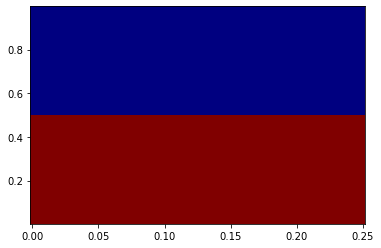

In [49]:
plt.pcolormesh(x.T,y.T,U[0].T,cmap='jet')

In [10]:
def MalhaRetangular(N):
   Δ = 10.0/N
   Δx = Δ; Δy = Δ
   x = API_Numpy.arange(-5.0,5.0+Δx,Δx)
   y = API_Numpy.arange(-1.0,1.0,Δy)

   X = API_Numpy.stack([x]*y.shape[0],axis=1)
   Y = API_Numpy.stack([y]*x.shape[0],axis=0)

   return X, Y, Δ

def CondiçãoInicialShockEntropy2D(X, Y, γ,θ):
   R = API_Numpy.zeros(X.shape)
   P = API_Numpy.ones(X.shape)
   U = API_Numpy.zeros(X.shape)
   V = API_Numpy.zeros(X.shape)

   I = API_Numpy.ones(X.shape)

   l=X < -4
   r=X >=-4

   R[l]=I[l]*27.0/7.0
   U[l]=I[l]*4.0*API_Numpy.sqrt(35.0)/9.0
   P[l]=I[l]*31.0/3.0

   R[r] = 1.0 + API_Numpy.sin(X[r]*API_Numpy.cos(θ)*2.0*API_Numpy.pi + Y[r]*API_Numpy.sin(θ)*2.0*API_Numpy.pi)/5.0

   E = P/(γ-1.0) + R*(U**2 + V**2)/2.0
   Q0 = API_Numpy.stack([R, R*U, R*V, E],axis=0)
   return Q0

def CondiçãoInicialShockEntropy2D_N(N, γ,θ):
   X, Y, Δ = MalhaRetangular(N)
   Q0 = CondiçãoInicialShockEntropy2D(X, Y, γ,θ)
   return X, Y, Δ, Q0

def NullForce(Q,API):
   return 0.0

In [29]:
x.shape

(251, 50)

In [45]:
γ = 7.0/5.0
θ = API_Numpy.pi/6.0
N = 250
Δx= Δ
x, y, Δ, U0 = CondiçãoInicialShockEntropy2D_N(N, γ,θ)
cfl = 0.5
t_final = 1.8

In [46]:
def ShockEntropy2DGhostPointsX(Q,API):
    ρl, ul, pl = 27.0/7.0, 4.0*API.cast(API.sqrt(35.0),'float64')/9.0, 31.0/3.0
    El = pl/(γ-1.0) + ρl*(ul**2)/2.0
    El = API.cast(El,'float64')

    raw_ref_shape=API.shape(Q)[:-3]
    out_shape=API.concat([API.shape(Q)[:-2],[3],API.shape(Q)[-1:]],axis=0)
    ref_shape=API.concat([API.ones(API.shape(raw_ref_shape),dtype='int32'),[4],[1],[1]],axis=0)

    vals_left=API.reshape([ρl, ρl*ul, 0.0, El],ref_shape)

    Xr = API.reshape([5.0+Δx, 5.0+2*Δx, 5.0+3*Δx], [3, 1])
    Yr = y[...,:3,:]
    ρr = 1.0 + API.sin(5.0*Xr*API.cos(θ) + 5.0*Yr*API.sin(θ))/5.0
    pr = API.ones(ρr.shape)
    ur = API.zeros(ρr.shape)
    vr = API.zeros(ρr.shape)
    Er = pr/(γ-1.0)
    Qr = API.stack([ρr, ur, vr, Er],axis=-3)

    Qg = [API.ones(out_shape,'float64')*API.cast(vals_left,'float64'),
    Q,
    API.cast(Qr,'float64')]

    return API.concat(Qg,-2)

def ShockEntropy2DGhostPointsY(Q,API):
    Qg = API.concat(
        [Q[...,:,-3:],
            Q,
            Q[...,:,:3]],axis=-1)
    return Qg

In [47]:
for WENO_type,name in zip([
    WENO_Z_sim,
    WENO_Zp_sim,
    WENO_Z_MS_sim,
    WENO_Zp_MS_sim,
    WENO_Z_BI_sim,
    WENO_ZC_MS_sim,
    WENO_ZC_BI_sim
    ],
    [
    'WENO-Z',
    'WENO-Z+',
    'WENO-Z (MS)',
    'WENO-Z+ (MS)',
    'WENO-Z (BI)',
    'WENO-ZC (MS)',
    'WENO-ZC (BI)'
    ]):
    U=U0.copy()
    t=0
    count=0
    if not(os.path.isdir(f'imagens/shockdensity2D-{name}/')):
            os.mkdir(f'imagens/shockdensity2D-{name}/')
    if not(os.path.isdir(f'imagens/shockdensity2D-Zoom-{name}/')):
            os.mkdir(f'imagens/shockdensity2D-Zoom-{name}/')
    while t<t_final:
        Λ  = WENO_type.equation.maximum_speed(U)
        Δt = Δ*cfl/Λ
        Δt = np.where(t+Δt>t_final,t_final-t,Δt)

        U=WENO_type.Sim_step(U, Δt, Δ, Δ, ShockEntropy2DGhostPointsX, ShockEntropy2DGhostPointsY,NullForce)
        t+=Δt
        print(t,end='\r')
        plt.figure(figsize=(16,8))
        ref_U=U[0].numpy()
        a=plt.pcolormesh(x.T,y.T,ref_U.T,cmap='jet',vmin=0.75,vmax=4.75)
        plt.colorbar(a)
        plt.contour(x.T,y.T,ref_U.T,levels=15,vmin=0.75,vmax=4.75,colors='black',linewidths=0.5)
        plt.title(name)
        count+=1
        plt.savefig(f'imagens/shockdensity2D-{name}/{count}.png')
        plt.close()

        plt.figure(figsize=(16,8))
        ref_U=U[0].numpy()
        a=plt.pcolormesh(x.T,y.T,ref_U.T,cmap='jet',vmin=0.75,vmax=4.75)
        plt.colorbar(a)
        plt.contour(x.T,y.T,ref_U.T,levels=15,vmin=0.75,vmax=4.75,colors='black',linewidths=0.5)
        plt.title(name)
        count+=1
        plt.savefig(f'imagens/shockdensity2D-Zoom-{name}/{count}.png')
        plt.close()

    with open(name+'.bkp','wb') as file:
        dill.dump(U,file)

    plt.figure(figsize=(16,8))
    ref_U=U[0].numpy()
    a=plt.pcolormesh(x.T,y.T,ref_U.T,cmap='jet',vmin=0.75,vmax=4.75)
    plt.colorbar(a)
    plt.contour(x.T,y.T,ref_U.T,levels=15,vmin=0.75,vmax=4.75,colors='black',linewidths=0.5)
    plt.title(name)
    #plt.xlim((0,3))
    plt.savefig('shockdensity2D'+name+'.png')
    plt.close()

    plt.figure(figsize=(16,8))
    ref_U=U[0].numpy()
    a=plt.pcolormesh(x.T,y.T,ref_U.T,cmap='jet',vmin=0.75,vmax=4.75)
    plt.colorbar(a)
    plt.contour(x.T,y.T,ref_U.T,levels=15,vmin=0.75,vmax=4.75,colors='black',linewidths=0.5)
    plt.title(name)
    plt.xlim((0,3))
    plt.savefig('shockdensity2D-zoom'+name+'.png')
    plt.close()

In [44]:
for WENO_type,name in zip([
    WENO_Z_sim,
    WENO_Zp_sim,
    WENO_Z_MS_sim,
    WENO_Zp_MS_sim,
    WENO_Z_BI_sim,
    WENO_ZC_MS_sim,
    WENO_ZC_BI_sim
    ],
    [
    'WENO-Z',
    'WENO-Z+',
    'WENO-Z (MS)',
    'WENO-Z+ (MS)',
    'WENO-Z (BI)',
    'WENO-ZC (MS)',
    'WENO-ZC (BI)'
    ]):
    U=U0.copy()
    t=0
    count=0

    with open(name+'.bkp','rb') as file:
        U=dill.load(file)

    plt.figure(figsize=(16,8))
    ref_U=U[0].numpy()
    a=plt.pcolormesh(x.T,y.T,ref_U.T,cmap='jet',vmin=0.75,vmax=4.75)
    plt.colorbar(a)
    plt.contour(x.T,y.T,ref_U.T,levels=15,vmin=0.75,vmax=4.75,colors='black',linewidths=0.5)
    plt.title(name)
    #plt.xlim((0,3))
    plt.savefig('shockdensity2D'+name+'.png')
    plt.close()

In [18]:
API_Numpy.min(ref_U)

0.7887306367423698